<a href="https://colab.research.google.com/github/cric96/DL-exercise/blob/main/DL_01_seoul_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary part

## Important imports

library reference:
- [pandas](https://pandas.pydata.org/docs/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://numpy.org/doc/stable/)
- [sklearn](https://scikit-learn.org/stable/)
- [tensorflow](https://www.tensorflow.org/api_docs)

In [ ]:
import glob 
from datetime import datetime
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

seed = 42

## Dataset gathering

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData

--2021-03-17 11:16:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 604166 (590K) [application/x-httpd-php]
Saving to: ‘SeoulBikeData’

SeoulBikeData       100%[===================>] 590.01K  --.-KB/s    in 0.1s    

2021-03-17 11:16:03 (4.14 MB/s) - ‘SeoulBikeData’ saved [604166/604166]



In [ ]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_xlim([1,epoch_count])
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10))
  
  for i in range(len(output_labels)):
    axs[0,i].set_title(output_labels[i])
    axs[0,i].scatter(y[:,i], y_pred[:,i],s=1)
    axs[0,i].set_xlabel('True Values')
    if i==0:
      axs[0,i].set_ylabel('Predictions')
    max_value=max(max(y[:,i]),max(y_pred[:,i]))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y[:,i]),min(y_pred[:,i])), max_value]
    axs[0,i].set_xlim(x_lims)
    axs[0,i].set_ylim(y_lims)
    axs[0,i].plot(y_lims, y_lims, color='k')

    errors = y[:,i]-y_pred[:,i]
    axs[1,i].hist(errors, bins=bin_count)
    axs[1,i].set_xlabel('Prediction Error')
    if i==0:
      axs[1,i].set_ylabel('Count')
    axs[1,i].set_xlim([min(errors),max(errors)])

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10))

  def init_plot(top_plot, bottom_plot):
    top_plot.set_ylabel('Predictions')
    bottom_plot.set_ylabel('Count')
    
  def plot_single(top_plot, bottom_plot, y, y_pred, label):
    top_plot.set_title(label)
    top_plot.scatter(y, y_pred, s = 1)
    top_plot.set_xlabel('True Values')
    
    max_value=max(max(y),max(y_pred))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y),min(y_pred)), max_value]
    top_plot.set_xlim(x_lims)
    top_plot.set_ylim(y_lims)
    top_plot.plot(y_lims, y_lims, color='k')

    errors = y - y_pred
    bottom_plot.hist(errors, bins=bin_count)
    bottom_plot.set_xlabel('Prediction Error')
    bottom_plot.set_xlim([min(errors),max(errors)])

  if len(output_labels) == 1:
    init_plot(axs[0], axs[1])
    plot_single(axs[0], axs[1], y, y_pred, output_labels[0])
  else:
    init_plot(axs[0,0], axs[1,0])
    for i in range(len(output_labels)):
      plot_single(axs[0,i], axs[1, i], y[:,i], y_pred[:,i], output_labels[i])

## Dataset analisys and trasformation
The dataset contains count of public bikes rented at each hour in Seoul Bike haring System with the corresponding Weather data and Holidays information.
(from https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand)

**Attributes**
- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour
- Hour - Hour of he day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

The categorial attributes seems to be *Holiday*, *FunctionalDay*, and *Seasons*. Here I think that we could use whether label encoding as one hot encoding.

The regression target is Rented Bike count.


### Basic analysis

In [ ]:
data_set = pd.read_csv("SeoulBikeData", header = 0, encoding = "unicode_escape")

In [ ]:
data_set.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

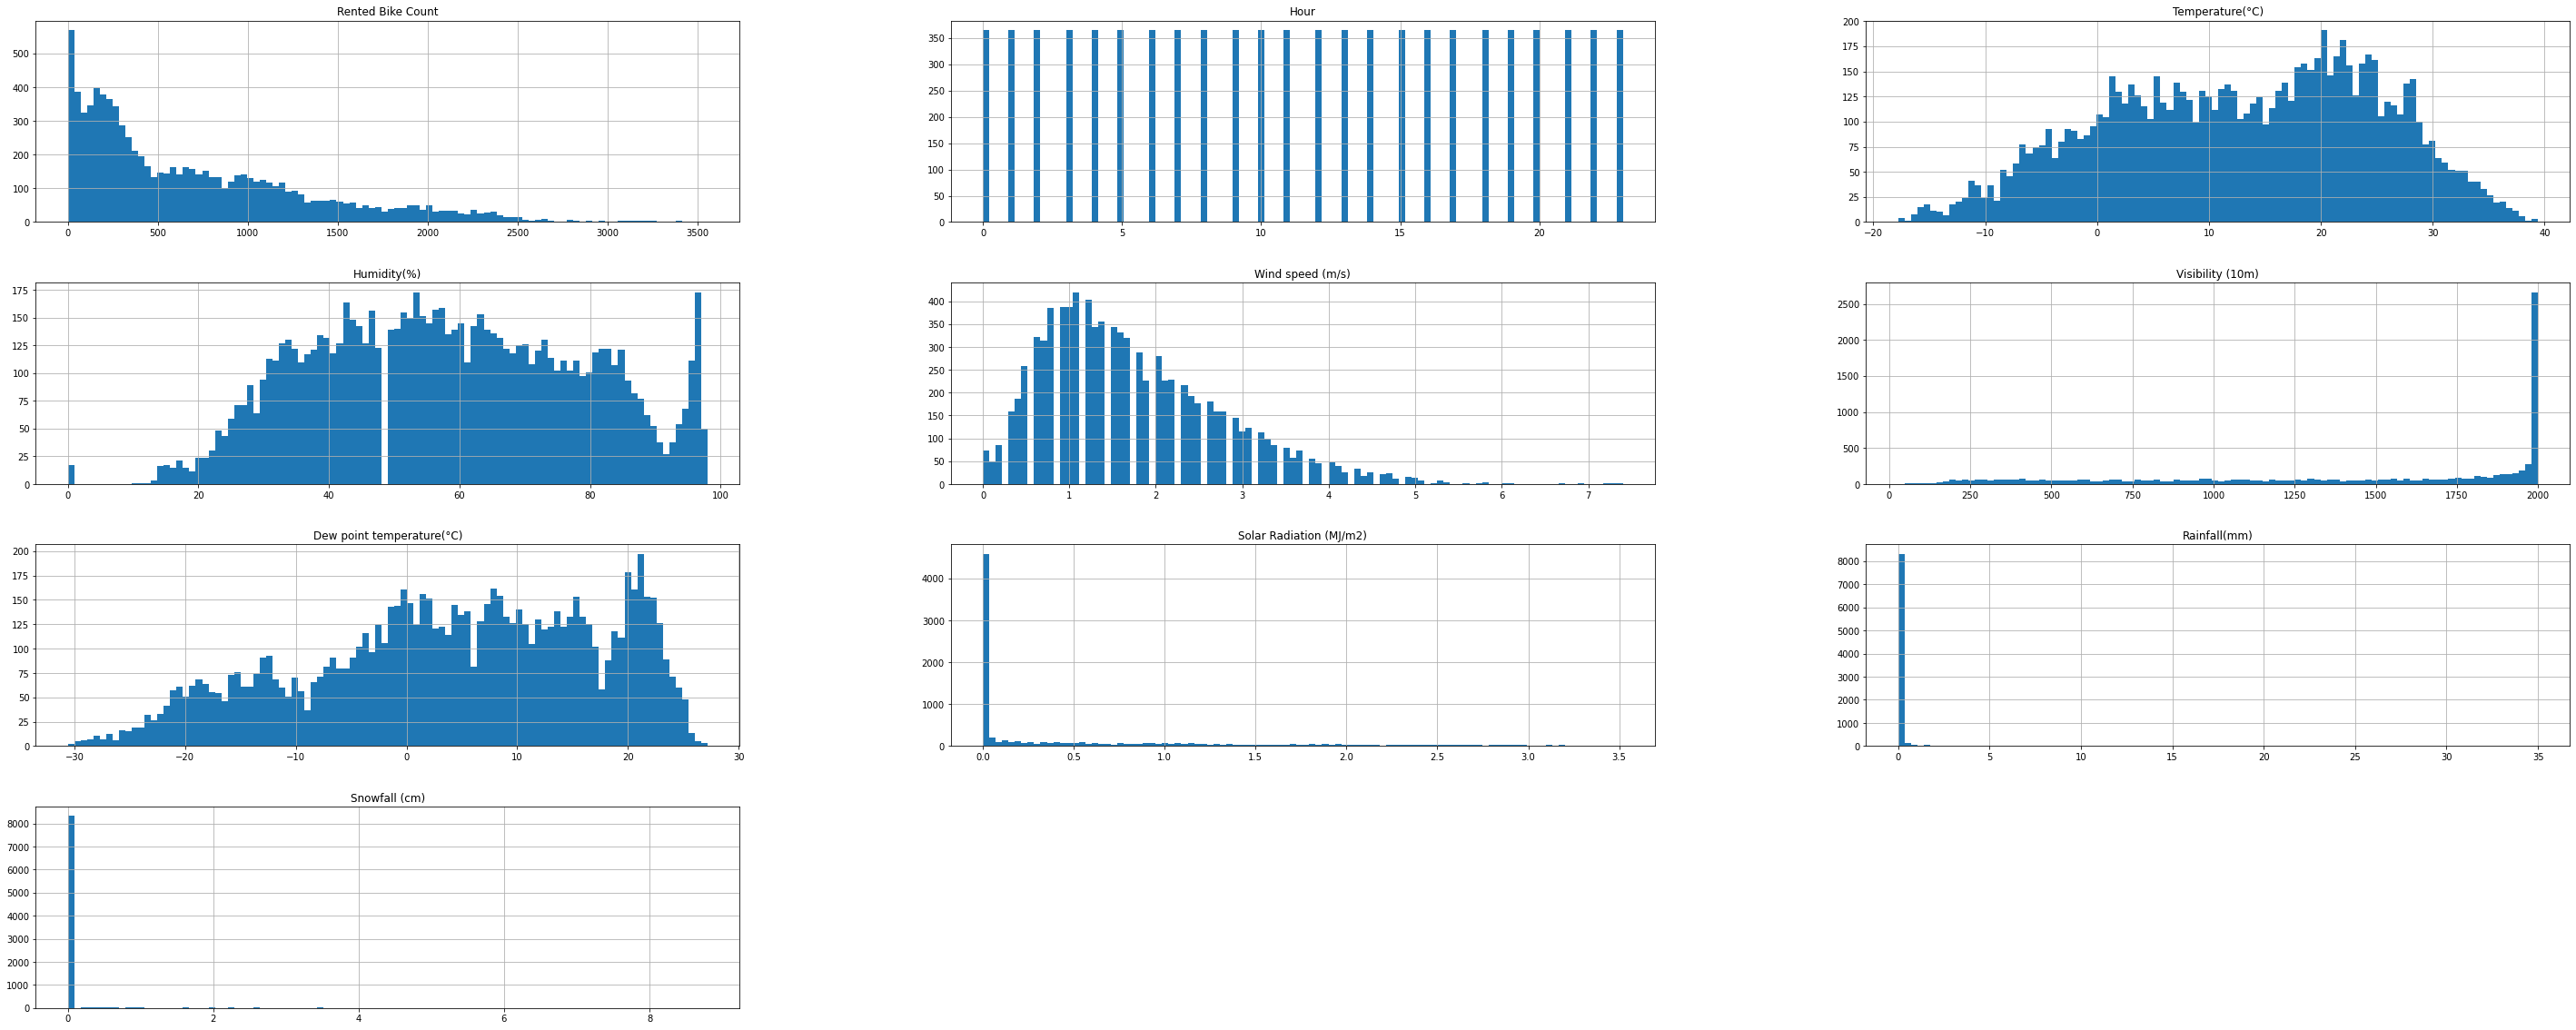

In [ ]:
## Visual information about data
data_set.hist(bins = 100, figsize = (50, 20))
plt.show()

In [ ]:
data_set.columns ## Get all attributes

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9828668250>,
      dtype=object)

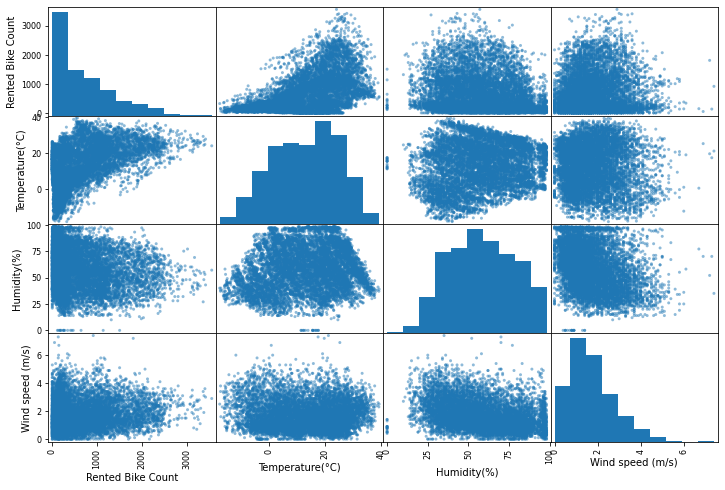

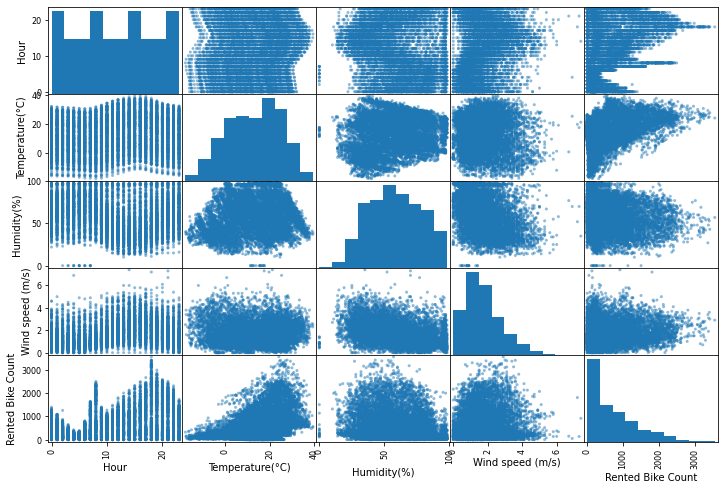

In [ ]:
# Correlation between revelevant data
cor_with_rentend = ["Rented Bike Count", "Temperature(°C)", "Humidity(%)", "Wind speed (m/s)"]
scatter_matrix(data_set[cor_with_rentend], figsize = (12, 8))
cor_with_hours = ["Hour", "Temperature(°C)", "Humidity(%)", "Wind speed (m/s)", "Rented Bike Count"]
scatter_matrix(data_set[cor_with_hours], figsize = (12, 8))

In [ ]:
corr_matrix = data_set.corr()
corr_matrix["Rented Bike Count"].sort_values(ascending = False)

Rented Bike Count            1.000000
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
Solar Radiation (MJ/m2)      0.261837
Visibility (10m)             0.199280
Wind speed (m/s)             0.121108
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
Name: Rented Bike Count, dtype: float64

### Categorical encoding

In [ ]:
reference = data_set.copy()
## label encoding 
def label_decoder(attr, df):
  res = df[[attr]]
  encoder = OrdinalEncoder()
  return encoder.fit_transform(res)

holiday_decoded = label_decoder("Holiday", reference)
functioning_day = label_decoder("Functioning Day", reference)
reference = pd.get_dummies(data_set, columns=["Seasons"], prefix=["Seasons"])
reference["Holiday"] = holiday_decoded
reference["Functioning Day"] = functioning_day
reference.sample(10)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
7655,15/10/2018,914,23,14.1,74,1.5,486,9.5,0.00,0.0,0.0,1.0,1.0,1,0,0,0
5034,28/06/2018,596,18,20.6,97,0.7,222,20.1,0.14,21.5,0.0,1.0,1.0,0,0,1,0
1468,31/01/2018,34,4,-2.4,82,1.5,877,-5.0,0.00,0.0,3.5,1.0,1.0,0,0,0,1
3352,19/04/2018,1198,16,19.8,25,4.4,1132,-0.8,2.02,0.0,0.0,1.0,1.0,0,1,0,0
739,31/12/2017,163,19,0.0,31,2.2,2000,-15.1,0.00,0.0,0.0,0.0,1.0,0,0,0,1
1507,01/02/2018,344,19,-1.8,32,1.5,2000,-16.3,0.00,0.0,0.0,1.0,1.0,0,0,0,1
3646,01/05/2018,1400,22,19.9,75,0.8,516,15.3,0.00,0.0,0.0,0.0,1.0,0,1,0,0
8541,21/11/2018,838,21,4.6,44,1.1,1859,-6.6,0.00,0.0,0.0,1.0,1.0,1,0,0,0
8095,03/11/2018,0,7,5.2,79,1.3,894,1.8,0.00,0.0,0.0,1.0,0.0,1,0,0,0
5606,22/07/2018,565,14,37.4,34,2.3,1860,18.8,3.05,0.0,0.0,1.0,1.0,0,0,1,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f982949f490>,
      dtype=object)

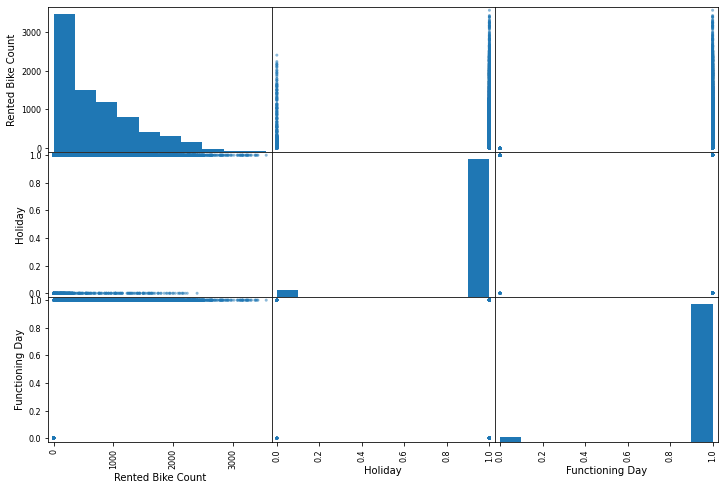

In [ ]:
## Correlation between categorial data
cor_with_rentend = ["Rented Bike Count", "Holiday", "Functioning Day"]
scatter_matrix(reference[cor_with_rentend], figsize = (12, 8))

## Data cleaning

In [ ]:
def to_month(date):
  converted = datetime.strptime(date, "%d/%m/%Y")
  return converted.month

if "Date" in reference.columns:
  reference["Month"] = reference["Date"].apply(to_month)
  reference = reference.drop("Date", axis = 1)
  reference = reference.drop("Dew point temperature(°C)", axis = 1)
reference.sample(1)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Month
586,133,10,-3.7,35,3.7,1937,0.57,0.0,0.0,0.0,1.0,0,0,0,1,12


# Learninig part


## Data set splitting

In [ ]:
target = ["Rented Bike Count"]
X = reference.drop(target, axis = 1).values
Y = reference[target].values
test_percentage = 0.25

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = seed, test_size = test_percentage, shuffle = True)

### Scaling the feature

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Reference performance, linear regression

RMSE - Train: 431.148 Test: 437.684


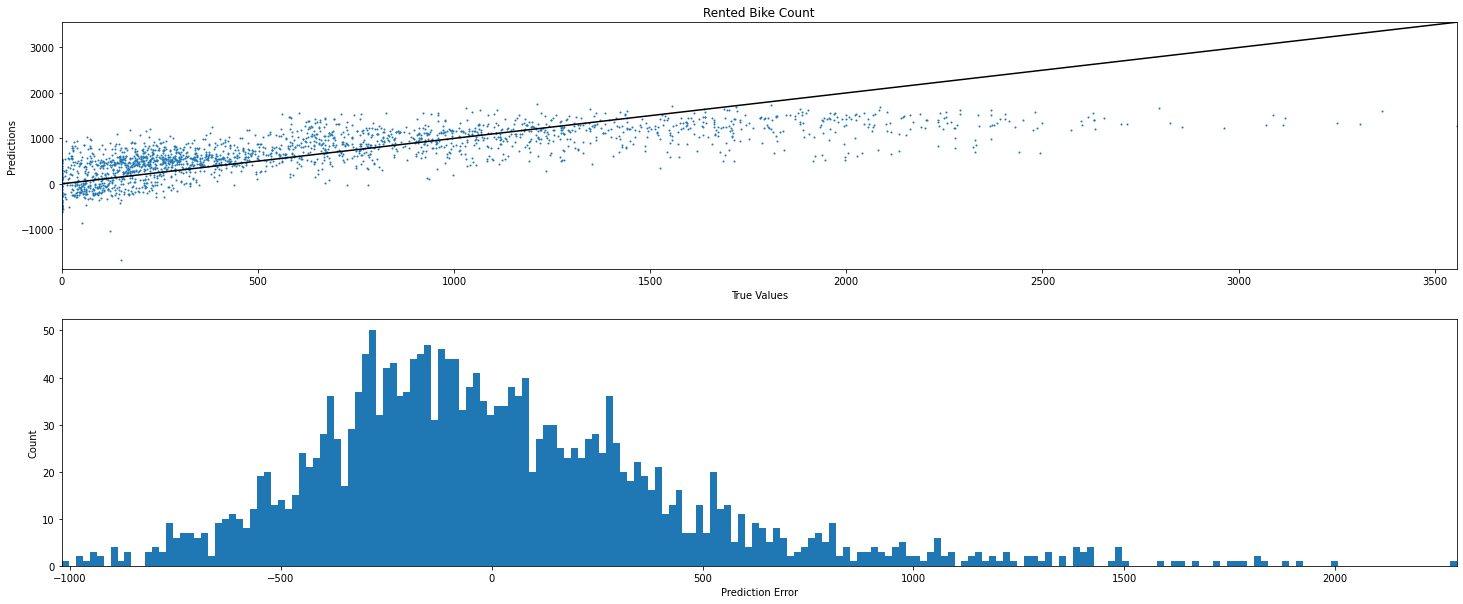

In [ ]:
linear_model = LinearRegression().fit(X_train, Y_train)

rmse_train_error = mean_squared_error(Y_train, linear_model.predict(X_train), squared = False)
rmse_test_error = mean_squared_error(Y_test, linear_model.predict(X_test), squared = False)

print('RMSE - Train: {:.3f} Test: {:.3f}'.format(rmse_train_error, rmse_test_error))

plot_prediction_results(Y_test, linear_model.predict(X_test), target, 200)

## Deep learning part

### Validation set creation

In [ ]:
val_size = 0.25

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = val_size, random_state = seed,shuffle = True)


In [ ]:
def build_dnn(input_count, output_count, neuron_count_per_hidden_layer = [128, 128], activation='relu'):
  model = keras.Sequential()
  model.add(layers.Input(shape=(input_count)))

  for n in neuron_count_per_hidden_layer:
    
    model.add(layers.Dense(n, activation = activation))

  model.add(layers.Dense(output_count))

  return model

Traning

In [ ]:
epoch_count = 10000
batch_size = 256
sgd_learning_rate = 0.00001
adam_learning_rate = 0.0001
patience = 50
dnn = build_dnn(X_train.shape[1], Y_train.shape[1], [128, 128, 64, 32], activation = 'relu') 
#optimizer = keras.optimizers.SGD(learning_rate = sgd_learning_rate)
#optimizer=keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta")
#optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate)
optimizer = keras.optimizers.Adam(learning_rate = adam_learning_rate)
dnn.compile(loss = 'mse', optimizer = optimizer, metrics = [keras.metrics.RootMeanSquaredError(name = 'rmse')])
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)

history = dnn.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=epoch_count, batch_size = batch_size, shuffle = True, callbacks= [early_stop])

Epoch 1/10000
20/20 [==============================] - 4s 22ms/step - loss: 912225.0208 - rmse: 954.8934 - val_loss: 880451.5625 - val_rmse: 938.3238
Epoch 2/10000
20/20 [==============================] - 0s 4ms/step - loss: 911246.7083 - rmse: 954.5227 - val_loss: 879798.6875 - val_rmse: 937.9758
Epoch 3/10000
20/20 [==============================] - 0s 4ms/step - loss: 931499.5476 - rmse: 965.1090 - val_loss: 878890.2500 - val_rmse: 937.4914
Epoch 4/10000
20/20 [==============================] - 0s 4ms/step - loss: 943092.6161 - rmse: 971.0974 - val_loss: 877617.9375 - val_rmse: 936.8126
Epoch 5/10000
20/20 [==============================] - 0s 4ms/step - loss: 919246.3512 - rmse: 958.7287 - val_loss: 875814.2500 - val_rmse: 935.8495
Epoch 6/10000
20/20 [==============================] - 0s 4ms/step - loss: 901546.2292 - rmse: 949.4085 - val_loss: 873209.6875 - val_rmse: 934.4569
Epoch 7/10000
20/20 [==============================] - 0s 4ms/step - loss: 931240.6786 - rmse: 964.9292 -

### Evaluation

RMSE - Train: 196.488 Val: 248.642 Test: 245.280


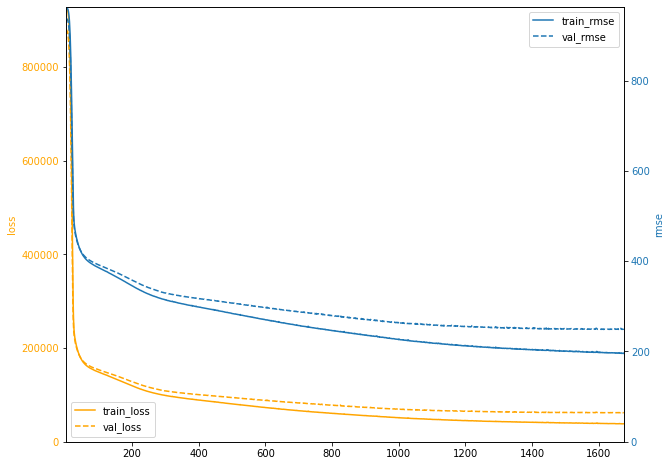

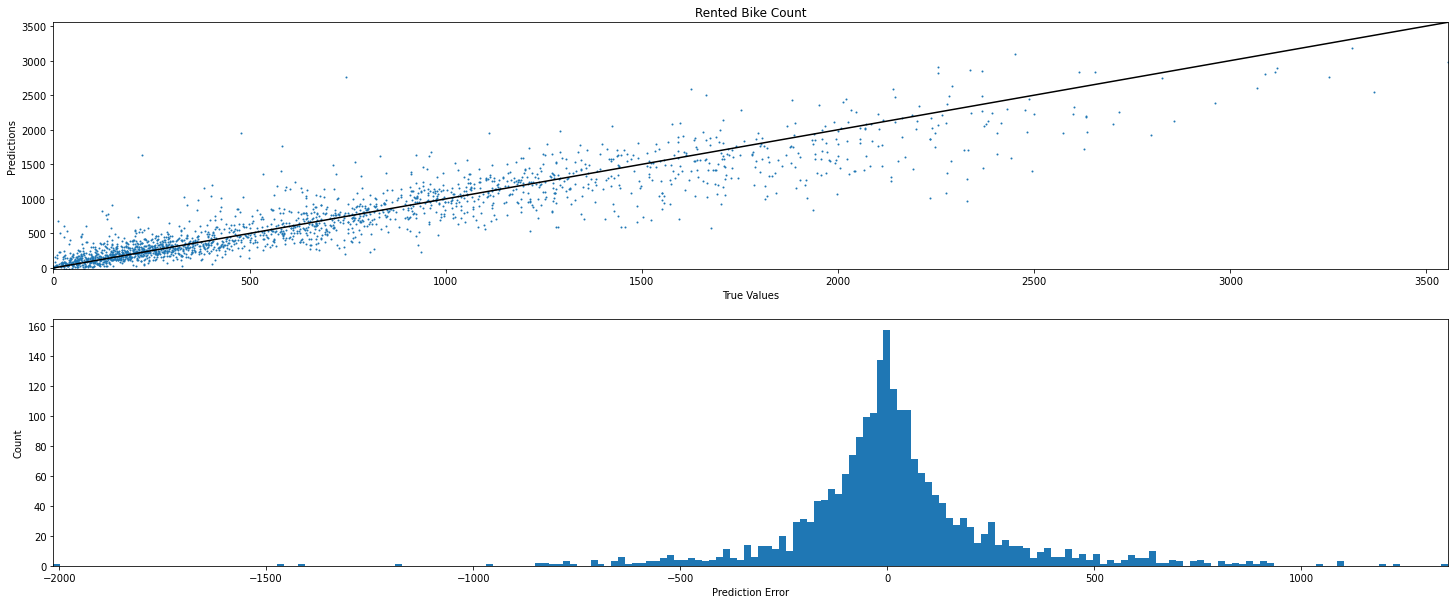

In [ ]:
Y_train_pred = dnn.predict(X_train)
Y_val_pred = dnn.predict(X_val)
Y_test_pred = dnn.predict(X_test)

plot_history(history, 'rmse')
plot_prediction_results(Y_test, Y_test_pred, target, 200)

rmse_train = mean_squared_error(Y_train ,Y_train_pred, squared = False)
rmse_val = mean_squared_error(Y_val, Y_val_pred, squared = False)
rmse_test = mean_squared_error(Y_test, Y_test_pred, squared = False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train,rmse_val,rmse_test))

In [ ]:
rmse_test_instances = np.sqrt(mean_squared_error(Y_test.transpose(),Y_test_pred.transpose(),multioutput='raw_values'))

rmse_test_instances_sorted_indices = np.argsort(rmse_test_instances)

row_count = 5

print("Best..")
with np.printoptions(precision = 1, suppress = True):
  print('RMSE:')
  print(rmse_test_instances[rmse_test_instances_sorted_indices[:row_count]])

  print('True values:')
  print(Y_test[rmse_test_instances_sorted_indices[:row_count]])

  print('Predicted values:')
  print(Y_test_pred[rmse_test_instances_sorted_indices[:row_count]])


print("Worst...")

with np.printoptions(precision = 1, suppress = True):
  print('RMSE:')
  print(rmse_test_instances[rmse_test_instances_sorted_indices[-row_count:]])

  print('True values:')
  print(Y_test[rmse_test_instances_sorted_indices[-row_count:]])

  print('Predicted values:')
  print(Y_test_pred[rmse_test_instances_sorted_indices[-row_count:]])

Best..
RMSE:
[0.2 0.2 0.2 0.4 0.4]
True values:
[[  0]
 [257]
 [  0]
 [  0]
 [  0]]
Predicted values:
[[  0.2]
 [256.8]
 [ -0.2]
 [ -0.4]
 [  0.4]]
Worst...
RMSE:
[1222.8 1355.7 1414.  1473.7 2013.8]
True values:
[[2234]
 [2329]
 [ 225]
 [ 477]
 [ 746]]
Predicted values:
[[1011.2]
 [ 973.3]
 [1639. ]
 [1950.7]
 [2759.8]]
